# Load Libraries

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns

# Import Data

In [41]:
# Loading the data
data = pd.read_csv('PredictorLSretWide.csv', parse_dates=['date'])
#data

In [42]:
data = data.sort_values('date')
data.set_index('date', inplace=True)

In [43]:
# Compute % of missing values across all predictors, year by year
missing_by_year = data.isnull().mean(axis=1).resample('Y').mean()

/var/folders/08/p26n4t9j3kd8rgcmmjf9mx6m0000gn/T/ipykernel_56972/595006155.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  missing_by_year = data.isnull().mean(axis=1).resample('Y').mean()


In [44]:
start_year = missing_by_year[missing_by_year < 0.15].index.min()

# Keep only data from this year onward
data = data[data.index >= start_year]
#data

In [45]:
col_missing_ratio = data.isnull().mean()
data = data.loc[:, col_missing_ratio <= 0.15]
#data

In [46]:
data = data.interpolate(method='linear')
data = data.fillna(method='ffill').fillna(method='bfill')
#data

/var/folders/08/p26n4t9j3kd8rgcmmjf9mx6m0000gn/T/ipykernel_56972/1981108245.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [47]:
# Extract momentum-related predictors for gt
momentum_keywords = ['Mom', 'Reversal', 'ResidualMomentum', 'LRreversal', 'MRreversal', 'STreversal']
momentum_cols = [col for col in data.columns if any(k in col for k in momentum_keywords)]

if not momentum_cols:
    raise ValueError("No momentum-related columns found. Adjust keyword list if needed.")

# Create gt matrix from selected momentum predictors (d × T)
gt = data[momentum_cols].transpose().values  # shape: (d, time)

# Remove gt columns from data to prevent leakage into rt
data_rt = data.drop(columns=momentum_cols)

# Create rt matrix from remaining predictors (N × T)
rt = data_rt.transpose().values

## Supervised Principal Components Analysis

compute the univariate correlation of each asset’s return with gt

In [48]:
rt = np.asarray(rt)  # shape: (N x T)
gt = np.asarray(gt)  # shape: (N x T)

num_assets = rt.shape[0]
num_factors = gt.shape[0]

# Initialise correlation matrix: (num_assets × num_factors)
correlations = np.empty((num_assets, num_factors))

# Compute correlation between each asset and each factor
for i in range(num_assets):
    for j in range(num_factors):
        corr = np.corrcoef(rt[i], gt[j])[0, 1]
        correlations[i, j] = corr


In [49]:
asset_names = data_rt.columns
factor_names = momentum_cols
correlation_df = pd.DataFrame(correlations, index=asset_names, columns=factor_names)
# Correlation_df gives a table where each row corresponds to an asset and each column to a momentum factor

Plot pairwise correlations on a heatmap

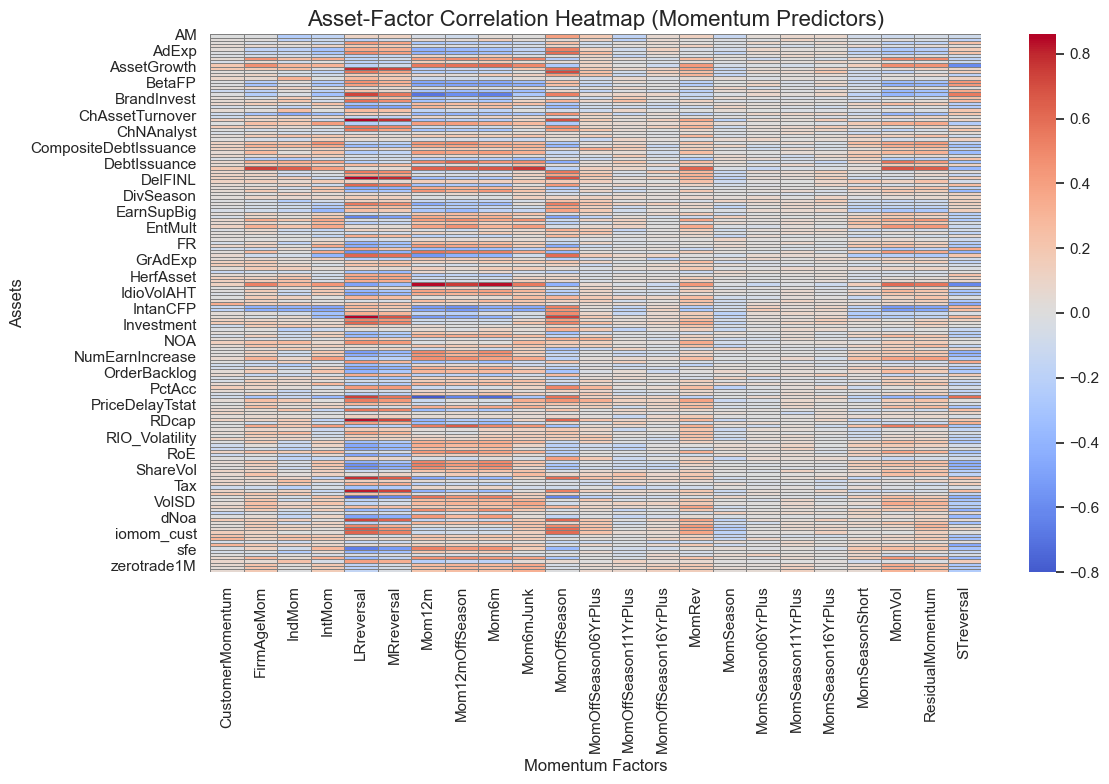

In [50]:
plt.figure(figsize=(12, 8))
sns.set(style="white")
sns.heatmap(correlation_df, cmap="coolwarm", center=0, annot=False, fmt=".2f", linewidths=0.5, linecolor='gray')
plt.title("Asset-Factor Correlation Heatmap (Momentum Predictors)", fontsize=16)
plt.xlabel("Momentum Factors")
plt.ylabel("Assets")
plt.tight_layout()
plt.show()

Next, we sample only assets that have a sufficiently high correlation in absolute value with the factors.

these are assets that are particularly informative about the factor of interest gt

In [51]:
# Threshold for absolute correlation
threshold = 0.7

# Create a boolean mask where any factor has |correlation| ≥ threshold
high_corr_mask = (correlation_df.abs() >= threshold).any(axis=1)
selected_assets = correlation_df.index[high_corr_mask].tolist() # Filter asset names with high correlation
rt_selected = rt[high_corr_mask, :] # Filter the rt matrix to keep only selected assets
correlation_df_selected = correlation_df.loc[selected_assets] #filetered correlation matrix

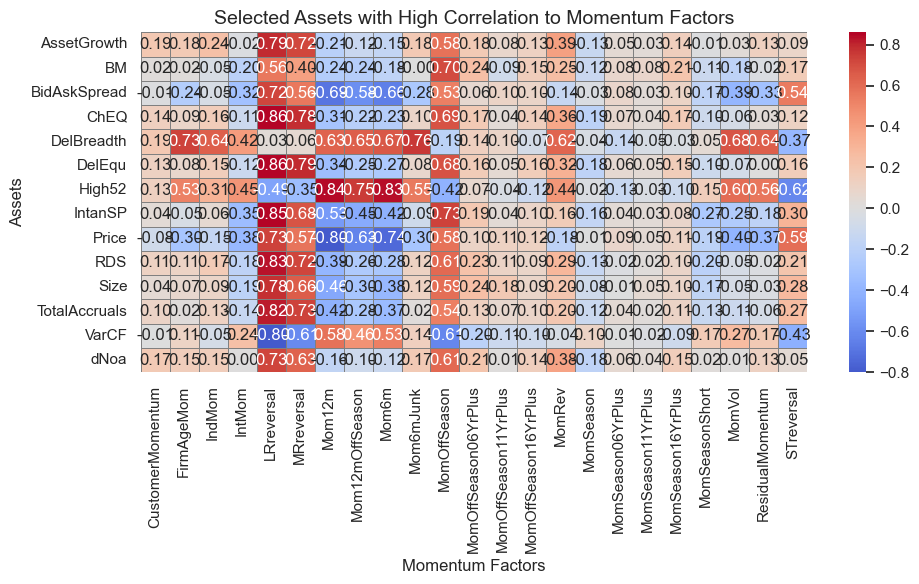

In [52]:
plt.figure(figsize=(10, max(6, len(selected_assets) * 0.4)))
sns.heatmap(correlation_df_selected, cmap="coolwarm", center=0, annot=True, fmt=".2f",
            linewidths=0.5, linecolor='gray')

plt.title("Selected Assets with High Correlation to Momentum Factors", fontsize=14)
plt.xlabel("Momentum Factors")
plt.ylabel("Assets")
plt.tight_layout()
plt.show()

Compute the first principal component of these portfolios (PCA step), which will be our first estimated latent factor

In [53]:
pca = PCA(n_components=1)
latent_factor = pca.fit_transform(rt_selected.T)  # shape: (time, 1)

# Flatten to 1D array if needed
latent_factor = latent_factor.flatten()

explained_var = pca.explained_variance_ratio_[0]
print(f"Explained variance by the first PC: {explained_var:.2%}")

Explained variance by the first PC: 70.40%


In [54]:
# Get PCA loadings (weights) for the first principal component
loadings = pca.components_[0]  # shape: (num_selected_assets,)

# Asset names from the correlation_df_selected
asset_names = correlation_df_selected.index

# Create a DataFrame to match loadings with asset names
loading_df = pd.DataFrame({
    'Asset': asset_names,
    'Loading': loadings
})

# Sort by absolute contribution (magnitude of loading)
loading_df['AbsLoading'] = loading_df['Loading'].abs()
loading_df_sorted = loading_df.sort_values(by='AbsLoading', ascending=False)

print(loading_df_sorted.head(10))

            Asset   Loading  AbsLoading
2    BidAskSpread  0.508532    0.508532
8           Price  0.484164    0.484164
12          VarCF -0.352625    0.352625
6          High52 -0.325124    0.325124
7         IntanSP  0.276914    0.276914
0     AssetGrowth  0.190887    0.190887
10           Size  0.180378    0.180378
5          DelEqu  0.170129    0.170129
11  TotalAccruals  0.169750    0.169750
3            ChEQ  0.154112    0.154112


Next, we remove via linear projection from both gt and all the returns of the test assets the part explained by this first latent factor (projection).

This is a residualisation step: we are removing the component of both the original factors gt and all test asset returns rt that is explained by the first latent factor. In other words, we're projecting out the influence of the latent factor.

* Prepare latent factor for regression
* Residualise gt (momentum factors)
* Residualise rt (all asset returns)

In [55]:
# Step 1
f = latent_factor.reshape(-1, 1)

# Step 2

# Transpose gt: shape (T, d)
gt_T = gt.T  # shape (T, num_factors)

# Project out the latent factor
beta_gt = np.linalg.lstsq(f, gt_T, rcond=None)[0]  # shape: (1, num_factors)

# Predicted component
gt_proj = f @ beta_gt  # shape: (T, num_factors)

# Residuals
gt_resid = gt_T - gt_proj  # shape: (T, num_factors)

# Transpose back: shape (num_factors, T)
gt_resid = gt_resid.T

#Step 3

# Transpose rt: shape (T, N)
rt_T = rt.T

# Project out the latent factor
beta_rt = np.linalg.lstsq(f, rt_T, rcond=None)[0]  # shape: (1, num_assets)
rt_proj = f @ beta_rt  # shape: (T, num_assets)
rt_resid = rt_T - rt_proj  # shape: (T, num_assets)

# Transpose back: shape (num_assets, T)
rt_resid = rt_resid.T

Now we need to repeat the procedure for calculating the first Principal Component. To save time we will from now on iterate through 5 times which is my a priori belief that will be enough to cover 99% + of the variation in factor returns explained by the assets.

* Select assets with |correlation| ≥ threshold (0.7).
* Run PCA on selected residualized returns to extract principal components
* Project out from both the Factor matrix g_t and Test return matrix r_t
* Repeat on new residuals.

In [56]:
p = 4  # number of latent factors to extract
threshold = 0.7  # correlation threshold
latent_factors = []  # to store the latent factors
loadings_list = []   # to store loadings for each factor

# Initialize residuals
gt_resid_k = gt.copy()
rt_resid_k = rt.copy()

explained_variances = []

for k in range(p):
    print(f"\n--- Iteration {k+1} ---")
    
    # Compute correlation between gt_resid_k and rt_resid_k
    corr_matrix = np.corrcoef(gt_resid_k, rt_resid_k)[:gt_resid_k.shape[0], gt_resid_k.shape[0]:]
    
    # Create correlation DataFrame
    corr_df = pd.DataFrame(corr_matrix.T, index=data_rt.columns, columns=momentum_cols)
    
    # Select assets with |correlation| >= threshold
    selected_mask = (corr_df.abs() >= threshold).any(axis=1)
    selected_assets = corr_df.index[selected_mask]
    print(f"Selected {len(selected_assets)} assets with high correlation")
    
    # If none selected, stop early
    if len(selected_assets) == 0:
        print("No more highly correlated assets found. Stopping early.")
        break

    # Build matrix of selected asset residual returns
    rt_selected_k = rt_resid_k[selected_mask.values, :]  # shape: (n_assets, T)
    
    # PCA to extract first component
    pca = PCA(n_components=1)
    f_k = pca.fit_transform(rt_selected_k.T).flatten()  # shape: (T,)

    explained_var = pca.explained_variance_ratio_[0]
    explained_variances.append(explained_var)
    
    # Save latent factor and loadings
    latent_factors.append(f_k)
    loadings_list.append((selected_assets.to_list(), pca.components_[0]))

    # Projection step: remove f_k from gt_resid_k and rt_resid_k
    f_k_reshaped = f_k.reshape(-1, 1)

    # Residualize gt
    beta_gt = np.linalg.lstsq(f_k_reshaped, gt_resid_k.T, rcond=None)[0]
    gt_resid_k = (gt_resid_k.T - f_k_reshaped @ beta_gt).T

    # Residualize rt
    beta_rt = np.linalg.lstsq(f_k_reshaped, rt_resid_k.T, rcond=None)[0]
    rt_resid_k = (rt_resid_k.T - f_k_reshaped @ beta_rt).T



--- Iteration 1 ---
Selected 14 assets with high correlation

--- Iteration 2 ---
Selected 2 assets with high correlation

--- Iteration 3 ---
Selected 0 assets with high correlation
No more highly correlated assets found. Stopping early.


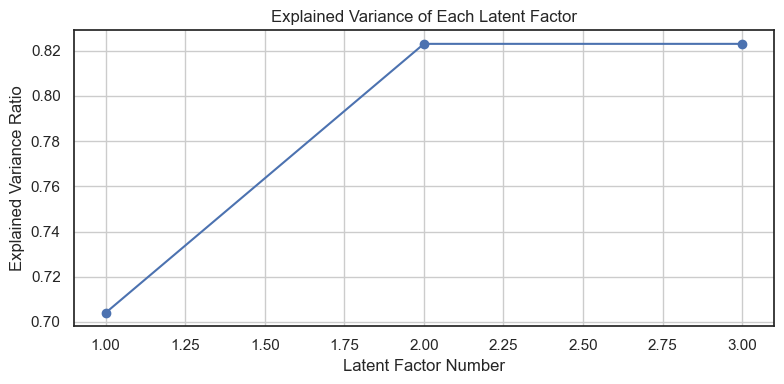

In [57]:
explained_var = pca.explained_variance_ratio_[0]
explained_variances.append(explained_var)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variances)+1), explained_variances, marker='o')
plt.title("Explained Variance of Each Latent Factor")
plt.xlabel("Latent Factor Number")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

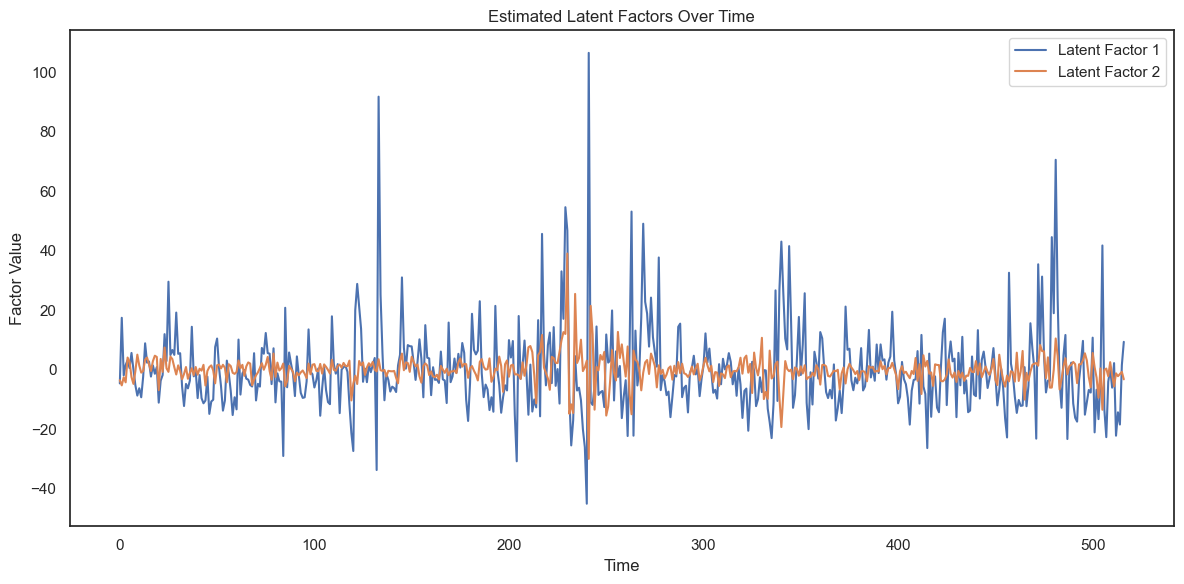

In [58]:
plt.figure(figsize=(12, 6))
for i, f in enumerate(latent_factors):
    plt.plot(f, label=f"Latent Factor {i+1}")

plt.title("Estimated Latent Factors Over Time")
plt.xlabel("Time")
plt.ylabel("Factor Value")
plt.legend()
plt.tight_layout()
plt.show()

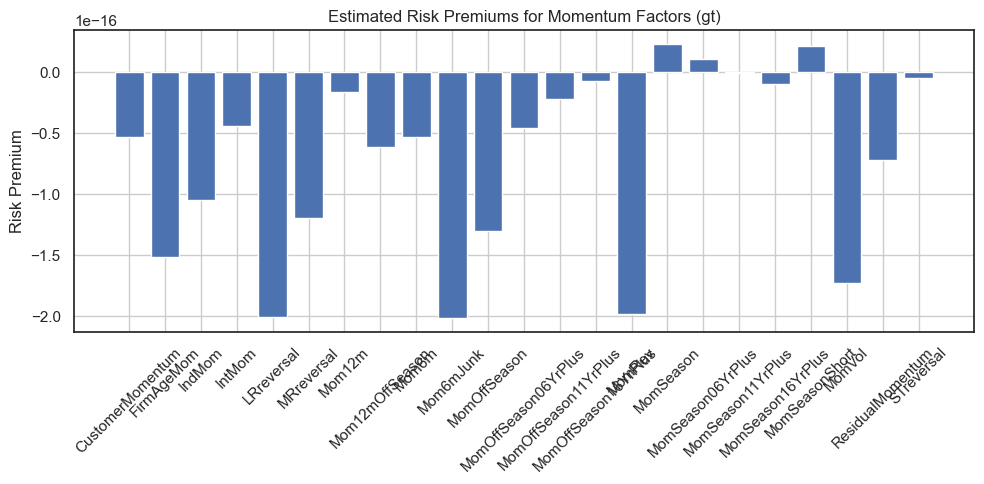

In [59]:
# Shape: (T, p)
F = np.column_stack(latent_factors)
gt_T = gt.T  # shape: (T, d)
# Run OLS regression for each column in gt
betas = np.linalg.lstsq(F, gt_T, rcond=None)[0]  # shape: (p, d)
risk_premia_latent = F.mean(axis=0)  # shape: (p,)
# Multiply exposures (betas) by latent factor premia
risk_premia_gt = betas.T @ risk_premia_latent  # shape: (d,)

plt.figure(figsize=(10, 5))
plt.bar(momentum_cols, risk_premia_gt)
plt.title("Estimated Risk Premiums for Momentum Factors (gt)")
plt.ylabel("Risk Premium")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


rt_selected shape: (14, 517)
risk_premia_rt shape: (14,)


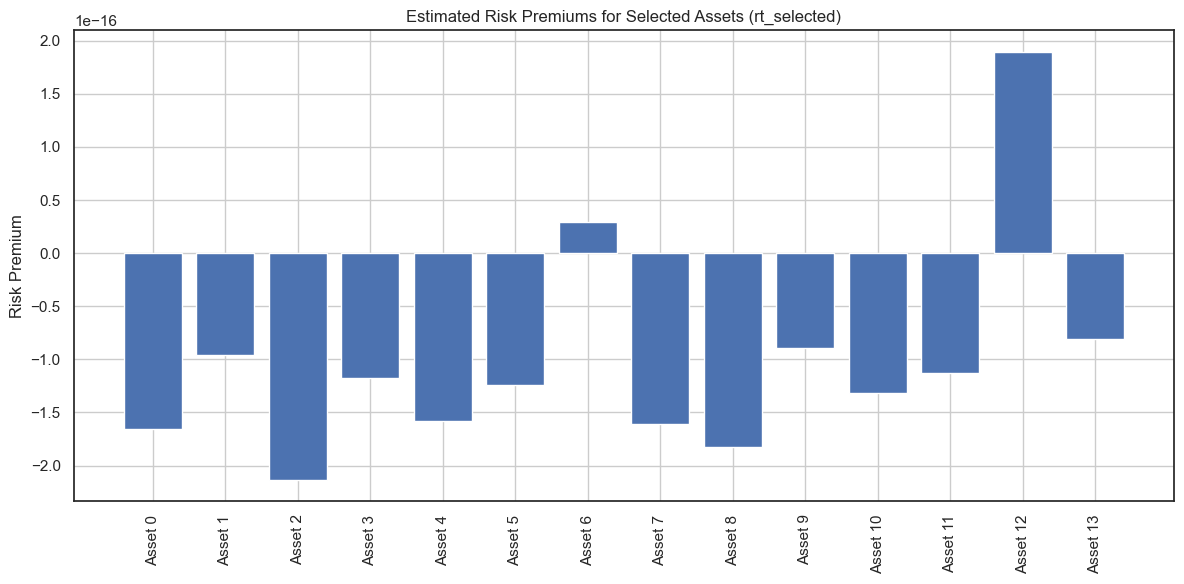

In [60]:
# Diagnostic prints
print("rt_selected shape:", rt_selected.shape)

# Compute
F = np.column_stack(latent_factors)
rt_T = rt_selected.T
betas_rt = np.linalg.lstsq(F, rt_T, rcond=None)[0]
risk_premia_latent = F.mean(axis=0)
risk_premia_rt = betas_rt.T @ risk_premia_latent

print("risk_premia_rt shape:", risk_premia_rt.shape)

# Always generate labels matching the length of risk_premia_rt
x_labels = [f"Asset {i}" for i in range(len(risk_premia_rt))]

plt.figure(figsize=(12, 6))
plt.bar(x_labels, risk_premia_rt)
plt.title("Estimated Risk Premiums for Selected Assets (rt_selected)")
plt.ylabel("Risk Premium")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()



Run Fama-Macbeth model to test significance of latent factor's explanatory power.

In [61]:
# Transpose rt_selected to shape (T, N)
R = rt_selected.T   # (T x N)
T, N = R.shape

# F is your factor matrix (T x p)
F = np.column_stack(latent_factors)  # (T x p)
p = F.shape[1]

# Add constant to factors if you want intercept (optional)
# F = np.column_stack([np.ones(T), F])

# Pre-allocate betas
betas = np.empty((N, p))

# Time series regression for each asset
for i in range(N):
    # OLS: R[:,i] ~ F
    b, _, _, _ = np.linalg.lstsq(F, R[:, i], rcond=None)
    betas[i, :] = b


In [62]:
# Pre-allocate lambdas (factor premia at each time)
lambdas = np.empty((T, p))

# For each time t, run cross-sectional regression across N assets:
# R[t, :] ~ betas
for t in range(T):
    # y = returns of all assets at time t
    y = R[t, :]  # shape: (N,)

    # X = betas (N x p)
    # OLS: y = betas * lambda_t
    lam_t, _, _, _ = np.linalg.lstsq(betas, y, rcond=None)
    lambdas[t, :] = lam_t


In [63]:
# Mean risk premia across time
mean_premia = lambdas.mean(axis=0)

# Standard errors (Newey-West not included here)
std_errors = lambdas.std(axis=0, ddof=1) / np.sqrt(T)

# Print results
for k in range(p):
    print(f"Factor {k+1}: Mean Premium = {mean_premia[k]:.6f}, Std Error = {std_errors[k]:.6f}")


Factor 1: Mean Premium = 0.596481, Std Error = 0.638023
Factor 2: Mean Premium = 1.218514, Std Error = 0.221840


In [64]:
t_stats = mean_premia / std_errors

# Print results
for k in range(len(mean_premia)):
    print(f"Factor {k+1}:")
    print(f"  Mean Premium = {mean_premia[k]:.6f}")
    print(f"  Std Error = {std_errors[k]:.6f}")
    print(f"  t-Statistic = {t_stats[k]:.2f}")
    if abs(t_stats[k]) > 1.96:
        print("  --> Statistically significant at 5% level")
    else:
        print("  --> Not statistically significant")
    print()


Factor 1:
  Mean Premium = 0.596481
  Std Error = 0.638023
  t-Statistic = 0.93
  --> Not statistically significant

Factor 2:
  Mean Premium = 1.218514
  Std Error = 0.221840
  t-Statistic = 5.49
  --> Statistically significant at 5% level

